<a href="https://colab.research.google.com/github/gheorghebg11/Shell/blob/master/Shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Shell Gas Station : interview for AI residency

## by Bogdan Gheorghe

## Load the files into Colab

The first cells are for loading the big data files from google drive (as colab only keeps the files for 12 hours), and the .csv from my google drive. We first install PyDrive and then authenticate and connect to google drive.

In [0]:
!pip install PyDrive
#!pip install -U tensorboardcolab
import os, zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!rm -r /content/sample_data

rm: cannot remove '/content/sample_data': No such file or directory


Now download the files and unzip the archives. Right now there are 4 folders for 4 different gas station brands.

In [0]:
#!rm -r /content/data
!mkdir /content/data
print('\nDownloading the data')
download = drive.CreateFile({'id': '1e5u2uDQ5mupV64KJbmWVG-JhlGKz9uUD'})
download.GetContentFile('/content/data_shell.tar.gz')
!tar -xzf /content/data_shell.tar.gz -C /content/data
print('Data successfully downloaded in /content/data')
!rm /content/data_shell.tar.gz

mkdir: cannot create directory ‘/content/data’: File exists

Data successfully downloaded in /content/data


## Data Visualization and Basic Cleaning (can be skipped)

First load some packages for Data Visualization.

In [0]:
import numpy as np
#np.random.seed(1989)

import cv2
from albumentations import Compose
import albumentations.augmentations.transforms as alb

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['axes.labelcolor'] = 'gray'
plt.rcParams['text.color'] = 'gray'
plt.rcParams['font.size'] = 15

import pandas as pd
pd.options.display.max_columns = 20

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

Now setup the working directory and get a list of the labels. Currently, there is one folder per label, containing all the images associated with that label.

We will now loop through all these files and do a few tasks:
- check for corrupted files (ending in .part)
- check for all available extensions, in order to exlcude non-images
- rename each file in the formal 'label_oldfilename' and move them all in one single folder.

In [0]:
dir_data = '/content/data/'
labels = list(os.listdir(dir_data))

extensions = set()

for label in labels:
    dir_label = os.path.join(dir_data, label)
    filenames = [name for name in os.listdir(dir_label) if os.path.isfile(os.path.join(dir_label, name))]
    
    for filename in filenames:
        new_filename = label + '_' + filename
        os.rename(os.path.join(dir_label, filename), os.path.join(dir_data,new_filename))
        
        # check for the extension
        extension = filename.split('.')[-1]
        if extension not in extensions:
            extensions.add(extension)
    
    # erase the empty folder (as we moved all the images in the main folder)
    os.rmdir(os.path.join(dir_data, label))

# create a list with all filenames 
filenames = [name for name in os.listdir(dir_data) if os.path.isfile(os.path.join(dir_data, name))]

print(f'We found a total of {len(filenames)} images, with the extensions {extensions}.')

We found a total of 776 images, with the extensions {'png', 'jpg', 'part', 'jpeg'}.


We will now erase the files ending in .part as they are corrupted images that failed during data mining. 

We also create a list with the images path, their label and their size in order to explore that data.

In [0]:
corrupted_files = 0
filenames_and_labels = []

for filename in filenames:
    if filename.endswith('.part'):
        corrupted_files = corrupted_files + 1
        os.remove(os.path.join(dir_data, filename))
    else:
        dims = cv2.imread(os.path.join(dir_data, filename)).shape
        filenames_and_labels.append((filename, filename.split('_')[0], dims[1], dims[0], dims[2], dims[0]*dims[1]))
        
print(f'We removed {corrupted_files} corrupted files out of {len(filenames)} total files, we are left with {len(filenames_and_labels)} images.')

We removed 7 corrupted files out of 776 total files, we are left with 769 images.


We now create a Pandas df with the data and explore it a little bit.

In [0]:
train = pd.DataFrame(filenames_and_labels, columns=['fname', 'label', 'xres', 'yres', 'channels', 'xyres'])
print(f'Train set has {train.shape[0]} examples and {len(set(train.label))} different labels. Here is a sample:')
train.sample(5)

Train set has 769 examples and 4 different labels. Here is a sample:


,fname,label,xres,yres,channels,xyres
128,chevron_299.jpg,chevron,800,600,3,480000
29,shell_63.png,shell,881,500,3,440500
283,conoco_39.jpg,conoco,500,750,3,375000
160,shell_95.jpg,shell,500,281,3,140500
702,conoco_94.jpg,conoco,1024,480,3,491520


Let's look at a sample from each label.

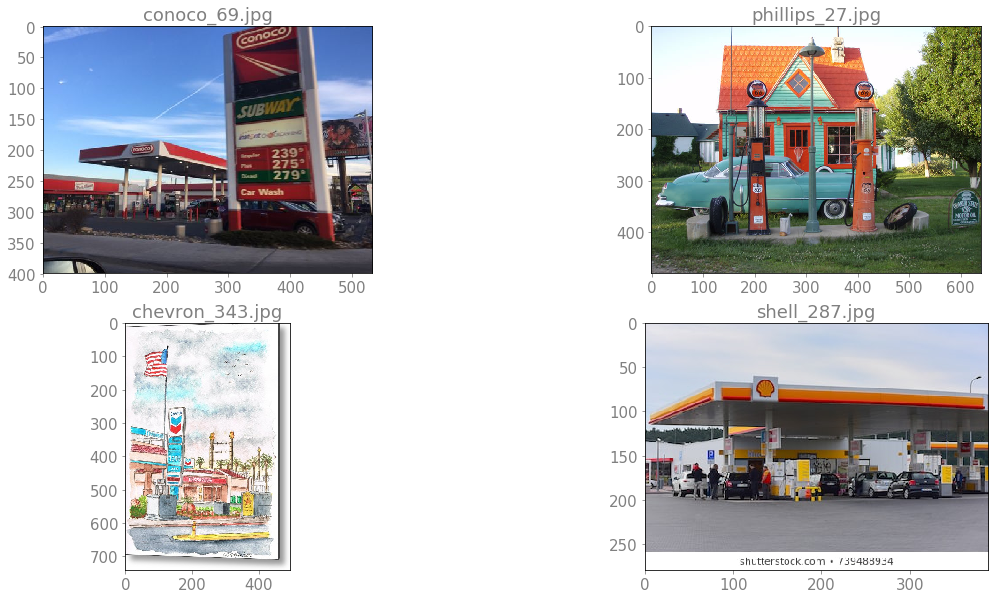

In [0]:
_, ax = plt.subplots(2,2, figsize=(20,10))

for i in range(2):
    for j in range(2):
        filename = train[train.label == labels[2*i + j]].sample(1).fname.values[0]
        file_path = os.path.join(dir_data, filename)
        img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR) # convert in normal colors
        
        ax[i,j].imshow(img)
        ax[i,j].set_title(filename)
plt.show()

Let's look at the distribution of samples per label.

The number of images per label ranges from 137 to 223


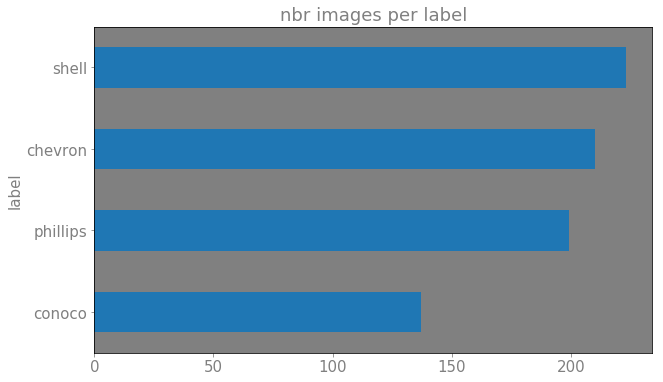

In [0]:
category_group = train[['fname', 'label']].groupby(['label']).count()
category_group.columns = ['counts']
print(f'The number of images per label ranges from {category_group.counts.min()} to {category_group.counts.max()}')
plot = category_group.sort_values(ascending=True, by='counts').plot(kind='barh', title='nbr images per label', figsize=(10,6), legend=False)
plt.show()

We look at the smallest and largest dimensions, and check that all photos have 3 channels.



The smallest x-resolution is 
fname       chevron_213.jpg
label               chevron
xres                    150
yres                    150
channels                  3
xyres                 22500
Name: 642, dtype: object

The smallest y-resolution is 
fname       conoco_378.jpeg
label                conoco
xres                    299
yres                    133
channels                  3
xyres                 39767
Name: 98, dtype: object

The distribution of channels is given by:


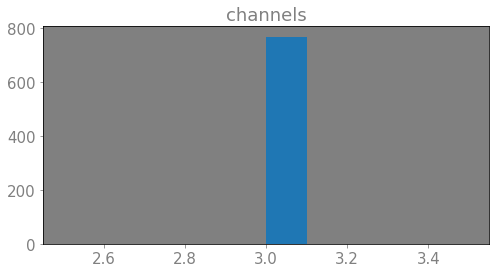

In [0]:
print(f'The smallest x-resolution is \n{train.loc[train.xres.idxmin()]}\n')
print(f'The smallest y-resolution is \n{train.loc[train.yres.idxmin()]}\n')

print('The distribution of channels is given by:')
train.hist(column='channels', figsize=(8,4), grid=False)
plt.show()

Let's now visualize the distribution of their dimensions:

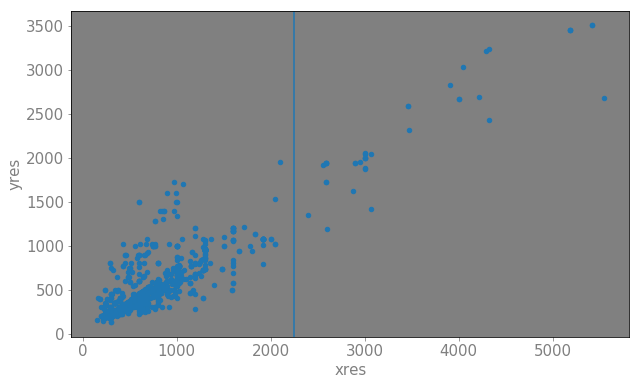

In [0]:
train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.axvline(x=2250)
plt.show()

We see that the scale on both axis are not the same and that most photos have a larger x-resolution. We will remove some outliers to avoid huge resolutions. Let's put the threshold at x-res < 2250. Let's also get rid of the lowest resolution ones, by requiering to at least have y-res > 150. Here is the new distribution of dimensions.

There are 39 images (out of 769) with x-resolution larger than 2250. We remove them and we are left with 730 images.
There are 3 images (out of 730) with y-resolution smaller than 150. We remove them and we are left with 726 images.
The smallest x-res or y-res is now 165.


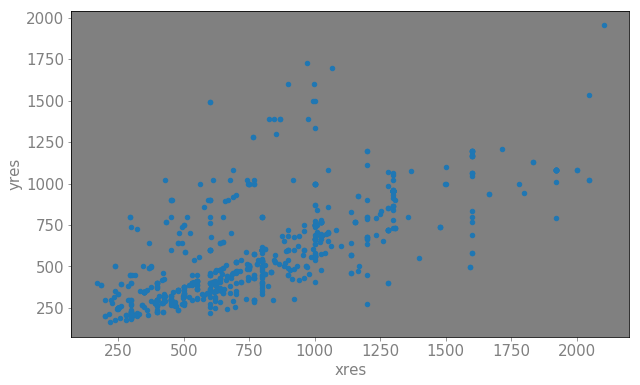

In [0]:
nbr_im_large_xres = train[train.xres > 2250].shape[0]
total_im = train.shape[0]
train = train.query('xres < 2250')

print(f'There are {nbr_im_large_xres} images (out of {total_im}) with x-resolution larger than 2250. We remove them and we are left with {train.shape[0]} images.')

nbr_im_small_yres = train[train.yres < 150].shape[0]
total_im = train.shape[0]
train = train.query('yres > 150')

print(f'There are {nbr_im_small_yres} images (out of {total_im}) with y-resolution smaller than 150. We remove them and we are left with {train.shape[0]} images.')

min_height_width = min(train['yres'].min(), train['xres'].min())
print(f'The smallest x-res or y-res is now {min_height_width}.')

train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.show()

The new data distribution looks like this:

The number of images per label ranges from 134 to 206


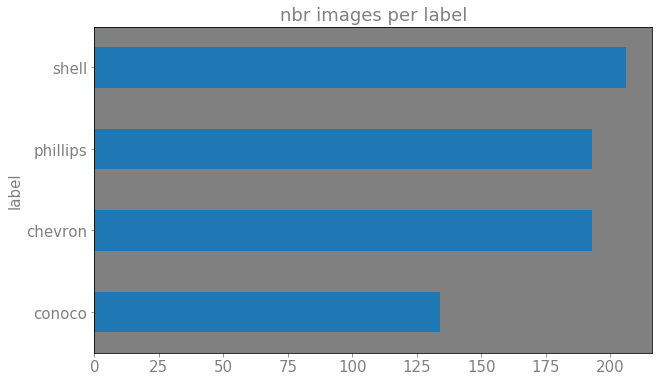

In [0]:
category_group = train[['fname', 'label']].groupby(['label']).count()
category_group.columns = ['counts']
print(f'The number of images per label ranges from {category_group.counts.min()} to {category_group.counts.max()}')
plot = category_group.sort_values(ascending=True, by='counts').plot(kind='barh', title='nbr images per label', figsize=(10,6), legend=False)
plt.show()

Let's look at a random sample, and see what our data augmentation filters do.

First resize the image so that no side is larger than 2 times the minimal size of 165, which avoids discarding too much of the image after cropping.
The number 2 becomes a hyperparameter.
We then pad by repeating the image, and then randomly crop a square of dimension 165x165, which we will feed to our CNN.
Here are 4 augmented images.


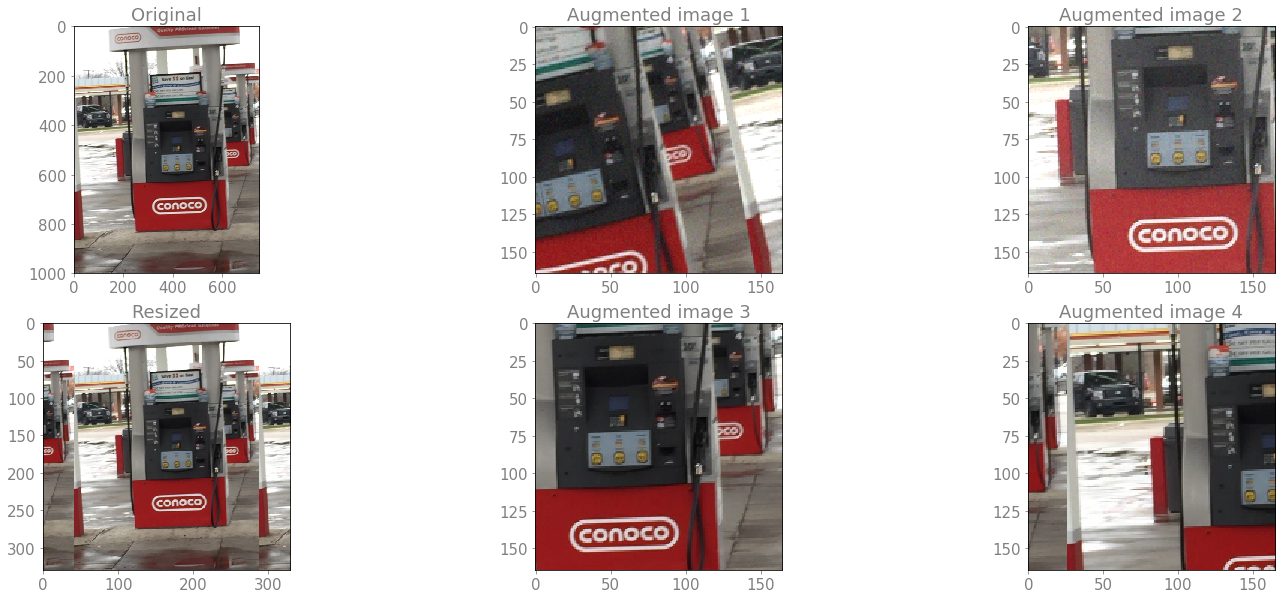

In [0]:
# the data augmentaion properties
augmentation = Compose([ 
    alb.RandomCrop(min_height_width,min_height_width, p=1.0),
    #alb.Blur(blur_limit=2),
    alb.RandomGamma(p=1.0),
    alb.Rotate(15),
    alb.RandomBrightnessContrast(),
    alb.GaussNoise(),
    alb.ToFloat(max_value=255)
])

# picking a sample and opening it
filename = train.sample(1).fname.values[0]
file_path = os.path.join(dir_data, filename)
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR) # convert in normal colors

_, ax = plt.subplots(2,3, figsize=(25,10))
ax[0,0].imshow(img)
ax[0,0].set_title('Original')

ratio_img_to_crop = max(img.shape[0]/min_height_width, img.shape[1]/min_height_width)
min_ratio = 2
if ratio_img_to_crop > min_ratio:
    img = cv2.resize(img,(int(img.shape[1] * min_ratio / ratio_img_to_crop), int(img.shape[0] * min_ratio / ratio_img_to_crop)))#, interpolation = cv2.INTER_CUBIC)
    img = alb.PadIfNeeded(min_height=min_ratio*min_height_width, min_width=min_ratio*min_height_width, border_mode=cv2.BORDER_WRAP)(image=img)["image"] ## IF PROBLEM USE MIN for crop and remove this.
    ax[1,0].imshow(img)
    ax[1,0].set_title('Resized')
    
print(f'First resize the image so that no side is larger than {min_ratio} times the minimal size of {min_height_width}, which avoids discarding too much of the image after cropping.')
print(f'The number {min_ratio} becomes a hyperparameter.')
print(f'We then pad by repeating the image, and then randomly crop a square of dimension {min_height_width}x{min_height_width}, which we will feed to our CNN.')
print('Here are 4 augmented images.')

count=1
for i in range(2):
    for j in range(1,3):
        ax[i,j].imshow(augmentation(image=img)["image"])
        ax[i,j].set_title(f'Augmented image {count}')
        count = count + 1

plt.show()

Finally we now save this cleaned dataframe containing the file names (in case we skip data visualization next time!).

In [0]:
train = train.drop(columns={'xyres', 'channels'})
train.to_csv(os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'shell_train.csv'), index=False)

## Construct The Model

First (Re)Load some Packages

In [0]:
import numpy as np
np.random.seed(1989)
np.set_printoptions(precision=2)

import shutil, cv2, urllib, time
import pandas as pd
pd.options.display.max_columns = 20

from albumentations import Compose
import albumentations.augmentations.transforms as alb

from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, Callback
from keras.layers import (Dense, Dropout, Input, Convolution2D, MaxPool2D, BatchNormalization, Flatten, Activation) 
from keras.utils import Sequence, to_categorical
from keras import backend as K

from sklearn.model_selection import StratifiedKFold
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

If you skipped the visualization section, download the dataframe and load it here. Also rename the files and move them in to a single folder.

In [0]:
download = drive.CreateFile({'id': '1d5CGjOx5Aqa21_p1PyZKLvk4PueQ2UoU'})
download.GetContentFile('/content/shell_train.csv')
train = pd.read_csv('/content/shell_train.csv')

dir_data = '/content/data'
labels = list(os.listdir(dir_data))

for label in labels:
    dir_label = os.path.join(dir_data, label)
    filenames = [name for name in os.listdir(dir_label) if os.path.isfile(os.path.join(dir_label, name))]

    for filename in filenames:
        new_filename = label + '_' + filename
        os.rename(os.path.join(dir_label, filename), os.path.join(dir_data,new_filename))
        
    # erase the empty folder
    os.rmdir(os.path.join(dir_data, label))


Set up 
- some paths
- the dictionnary transforming the label names in numbers (needed by tf)
- the min x-res and y-res values (we have to ensure that we will crop the image to bigger values)
- the filename as index for the training dataframe.

In [0]:
dir_data = '/content/data'

labels = train['label'].unique()
labels_to_idx = {label: i for i, label in enumerate(labels)}
idx_to_labels = {i: label for i, label in enumerate(labels)}
print(f'Here is the dictionnary for the labels: {labels_to_idx}')

n_classes = len(labels)

min_height = train['yres'].min()
min_width = train['xres'].min()
min_height_width = min(min_height, min_width)

print(f'The min height and width are {min_height} and {min_width}. These min values will be necessary for cropping the images.')

train.set_index('fname', inplace=True, drop=True)
train['label_idx'] = train.label.apply(lambda x: labels_to_idx[x])
train.head()

Here is the dictionnary for the labels: {'conoco': 0, 'phillips': 1, 'shell': 2, 'chevron': 3}
The min height and width are 165 and 168. These min values will be necessary for cropping the images.


,label,xres,yres,label_idx
fname,,,,
conoco_32.jpg,conoco,740,518,0
phillips_317.jpg,phillips,250,250,1
phillips_285.jpg,phillips,812,510,1
phillips_40.jpg,phillips,669,900,1
shell_287.jpg,shell,389,280,2


The Configuration class : In particular contains the default settings.

In [0]:
class Config(object):
	def __init__(self, model_name = 'dummy', n_classes=n_classes, image_size=(64,64,3), n_folds=1, n_preds = 1, learning_rate=0.0001, max_epochs=10):
		self.n_classes = n_classes
		self.image_size = image_size
		self.n_folds = n_folds
		self.n_preds = n_preds
		self.learning_rate = learning_rate
		self.max_epochs = max_epochs
		self.model_name = model_name

The Datagenerator class : Inherits from Keras.utils.Sequence to efficiently feed the data.

In [0]:
class DataGenerator(Sequence): # Inherits from Keras.utils.Sequence for multiprocessing

    def __init__(self, config, dir_data, list_IDs, labels=None,
					batch_size=16, shuffle=False, augmentation = None, min_ratio_crop=2, preprocessing_fn=None):
    
        self.config = config
        self.dir_data = dir_data
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.min_ratio_crop = min_ratio_crop
        self.preprocessing_fn = preprocessing_fn
        self.shuffle = shuffle
        
        # the following seems better than calling on_epoch_end, to avoid shuffle at beginning!
        self.indexes = np.arange(len(self.list_IDs))
        #self.on_epoch_end()
        

    # returns the number of batches in the Sequence (per 1 epoch)
    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    # returns the index^th complete batch
    def __getitem__(self,index):
        indexes_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes_temp]
        return self.__data_generation(list_IDs_temp)

    # called at the end of an epoch: reloads IDs
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.config.image_size)) 
        
        for i,ID in enumerate(list_IDs_temp):
            file_path = os.path.join(self.dir_data, ID)
                        
            # read the image
            img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR)
            #plt.figure(), plt.imshow(img), plt.show()
            
            # other preprocesses (not augmenting though)
            if self.preprocessing_fn:
                img = self.preprocessing_fn(img) 
            
            # augment and save in the big array X
            if self.augmentation:
                ratio_img_to_crop = max(img.shape[0]/self.config.image_size[0], img.shape[1]/self.config.image_size[1]) ## Could also use max and pad around it
                
                if ratio_img_to_crop > self.min_ratio_crop:
                    img = cv2.resize(img,(int(img.shape[1] * self.min_ratio_crop / ratio_img_to_crop), int(img.shape[0] * self.min_ratio_crop / ratio_img_to_crop)))
                    img = alb.PadIfNeeded(min_height=int(self.min_ratio_crop*min_height_width), min_width=int(self.min_ratio_crop*min_height_width), border_mode=cv2.BORDER_WRAP)(image=img)["image"] ## IF PROBLEM USE MIN for crop and remove this.
                    #plt.figure(), plt.imshow(img), plt.show()
                img = self.augmentation(image=img)["image"]
            
            # if it wasn't cropped or resized yet, we resize it so that it has the std size
            if img.shape != self.config.image_size:
                img = cv2.resize(img,(self.config.image_size[0],self.config.image_size[1]))

            #plt.figure(), plt.imshow(img), plt.show()
            X[i,] = img
        
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

A small class to save the training time for each epoch.

In [0]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Here is the dummy model with just a fully connected layer. Name = dummy

In [0]:
def get_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    out = Dense(nclass, activation=softmax)(inp)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

And the larger 2D conv model. Name = conv

In [0]:
def get_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    
    x = Convolution2D(64, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(64, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    #x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    #x = Dropout(rate=0.2)(x)
    
    '''
    x = Convolution2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    x = Convolution2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    #x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(512, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(512, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(512, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    #x = Dropout(rate=0.2)(x)
    '''
    
    x = Flatten()(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.2)(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    
    return model

## Run The Model!

Set-up the Paths for the data, and clear the folders if they already contain saved log files.

In [0]:
dir_log = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'logs')
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)

dir_pred = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'pred')
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)

dir_train = dir_data
dir_test = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'test')
os.mkdir(dir_test)

Creating the config and other necessary global objects that don't need to be reset after each k-fold. All hyperparameters are setup in this cell.

In [0]:
config = Config(n_folds=4, n_preds=10, model_name = 'conv', image_size=(min_height_width, min_height_width,3), learning_rate=0.01, max_epochs=150)

skf = StratifiedKFold(n_splits=config.n_folds)

use_Tensorboard = True
do_predictions_on_val_set = True

early_patience = 15

reduce_lr_factor = 0.4
reduce_lr_patience = 5

min_ratio_crop = 2.5

# Data augmentors
augmentation_train = Compose([ 
    alb.RandomCrop(min_height_width,min_height_width),
    #alb.Blur(blur_limit=2),
    alb.RandomGamma(),
    alb.Rotate(15),
    alb.RandomBrightnessContrast(),
    alb.GaussNoise(),
    alb.ToFloat(max_value=255)
])

augmentation_val = Compose([
    alb.RandomCrop(min_height_width,min_height_width),
    alb.Rotate(15),
    alb.ToFloat(max_value=255)
])

augmentation_test = Compose([
    alb.RandomCrop(min_height_width,min_height_width),
    alb.Rotate(15),
    alb.ToFloat(max_value=255)
])

# printing the model's architecture
K.clear_session()
if config.model_name == 'dummy':
    print('\nWe are using the dummy model.\n')
    model = get_dummy_model(config)
else:
    print('\nWe are using the convolutional model.\n')
    model = get_conv_model(config)
print(model.summary())


We are using the convolutional model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 165, 165, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 165, 165, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 165, 165, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 165, 165, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 82, 82, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 

We can finally train the model!



##################################################
Fold 0

Loading Tensorboard
Wait for 8 seconds...
TensorBoard link:
https://f82e27b9.ngrok.io


Epoch 1/150
17/17 [==============================] - 13s 762ms/step - loss: 2.3070 - acc: 0.2528 - val_loss: 7.6509 - val_acc: 0.1793
Epoch 2/150
17/17 [==============================] - 7s 398ms/step - loss: 1.4577 - acc: 0.3780 - val_loss: 2.4277 - val_acc: 0.3913
Epoch 3/150
17/17 [==============================] - 8s 497ms/step - loss: 1.5003 - acc: 0.3861 - val_loss: 1.6127 - val_acc: 0.4076
Epoch 4/150
17/17 [==============================] - 9s 529ms/step - loss: 1.5255 - acc: 0.3606 - val_loss: 2.2560 - val_acc: 0.4348
Epoch 5/150
17/17 [==============================] - 9s 503ms/step - loss: 1.3100 - acc: 0.4189 - val_loss: 1.7700 - val_acc: 0.2663
Epoch 6/150
17/17 [==============================] - 9s 504ms/step - loss: 1.3361 - acc: 0.4931 - val_loss: 1.9579 - val_acc: 0.3370
Epoch 7/150
17/17 [==============================] -

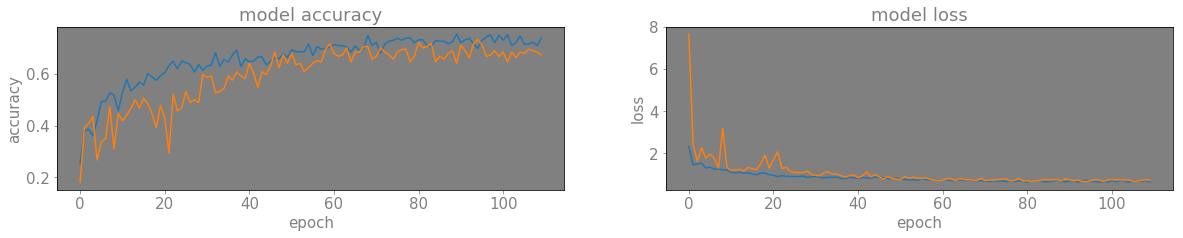


We will now do 10 different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.
Prediction number 1:
12/12 [==============================] - 2s 179ms/step
File val_pred_0_0 got 129 right out of 184, i.e, an accuracy of 0.70
Prediction number 2:
12/12 [==============================] - 2s 171ms/step
File val_pred_0_1 got 133 right out of 184, i.e, an accuracy of 0.72
Prediction number 3:
12/12 [==============================] - 2s 172ms/step
File val_pred_0_2 got 127 right out of 184, i.e, an accuracy of 0.69
Prediction number 4:
12/12 [==============================] - 2s 173ms/step
File val_pred_0_3 got 130 right out of 184, i.e, an accuracy of 0.71
Prediction number 5:
12/12 [==============================] - 2s 169ms/step
File val_pred_0_4 got 129 right out of 184, i.e, an accuracy of 0.70
Prediction number 6:
12/12 [==============================] - 2s 171ms/step
File val_pred_0_5 got 132 right out of 184, i.e, an accur

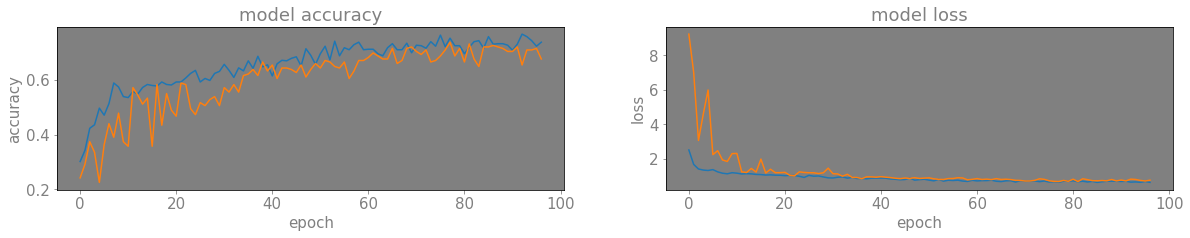


We will now do 10 different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.
Prediction number 1:
12/12 [==============================] - 2s 203ms/step
File val_pred_1_0 got 133 right out of 182, i.e, an accuracy of 0.73
Prediction number 2:
12/12 [==============================] - 2s 175ms/step
File val_pred_1_1 got 131 right out of 182, i.e, an accuracy of 0.72
Prediction number 3:
12/12 [==============================] - 2s 172ms/step
File val_pred_1_2 got 129 right out of 182, i.e, an accuracy of 0.71
Prediction number 4:
12/12 [==============================] - 2s 172ms/step
File val_pred_1_3 got 135 right out of 182, i.e, an accuracy of 0.74
Prediction number 5:
12/12 [==============================] - 2s 173ms/step
File val_pred_1_4 got 132 right out of 182, i.e, an accuracy of 0.73
Prediction number 6:
12/12 [==============================] - 2s 172ms/step
File val_pred_1_5 got 135 right out of 182, i.e, an accur

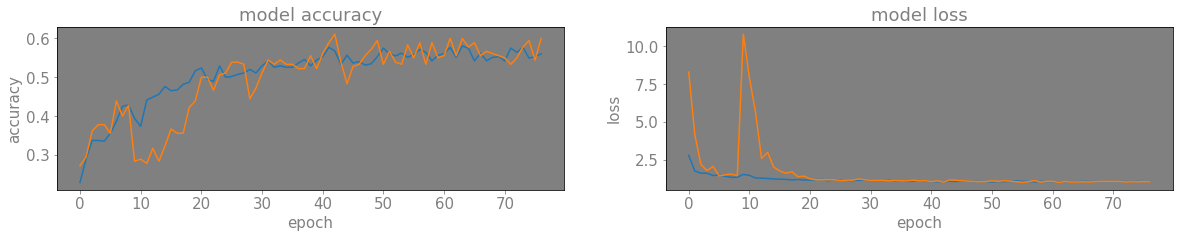


We will now do 10 different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.
Prediction number 1:
12/12 [==============================] - 2s 203ms/step
File val_pred_2_0 got 103 right out of 180, i.e, an accuracy of 0.57
Prediction number 2:
12/12 [==============================] - 2s 165ms/step
File val_pred_2_1 got 111 right out of 180, i.e, an accuracy of 0.62
Prediction number 3:
12/12 [==============================] - 2s 165ms/step
File val_pred_2_2 got 110 right out of 180, i.e, an accuracy of 0.61
Prediction number 4:
12/12 [==============================] - 2s 165ms/step
File val_pred_2_3 got 113 right out of 180, i.e, an accuracy of 0.63
Prediction number 5:
12/12 [==============================] - 2s 164ms/step
File val_pred_2_4 got 103 right out of 180, i.e, an accuracy of 0.57
Prediction number 6:
12/12 [==============================] - 2s 164ms/step
File val_pred_2_5 got 100 right out of 180, i.e, an accur

KeyboardInterrupt: ignored

In [0]:
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)

accuracy_val =[]
times_train =[]

for i, (train_idx, val_idx) in enumerate(skf.split(train.index, train.label_idx)):
    K.clear_session()
    print('\n')
    print('#'*50)
    print(f'Fold {i}')
    
    ########
    # Preparing for training
    ########
    
    # splitting the dataset, percentage depends on the number of n_folds
    train_set = train.iloc[train_idx]
    val_set = train.iloc[val_idx]
    
    # setting the callbacks
    callbacks_list= []
    # the checkpoint is causing issues with colab and breaks in the middle of training. A workaround is the restore_best_weights from EarlyStopping
    #checkpoint = ModelCheckpoint(os.path.join(dir_log,'best_%d.h5'%i), monitor='val_loss', verbose=1, save_best_only=True)
    #callbacks_list.append(checkpoint)  
    early = EarlyStopping(monitor='val_loss', mode='auto', patience=early_patience, restore_best_weights=True)
    callbacks_list.append(early)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=0.00001, verbose=1)
    callbacks_list.append(reduce_lr)
    time_callback = TimeHistory()
    callbacks_list.append(time_callback)
    
    if use_Tensorboard:
        tb = TensorBoard(log_dir= os.path.join(dir_log, 'fold_%d'%i), write_graph=True)
        callbacks_list.append(tb)
        print(f'\nLoading Tensorboard')
        tbc = TensorBoardColab()
        callbacks_list.append(TensorBoardColabCallback(tbc))
        print('\n')
    
    # choosing the model
    if config.model_name == 'dummy':
        model = get_dummy_model(config)
    else:
        model = get_conv_model(config)
    
    # setting the data generators
    train_generator = DataGenerator(config, dir_data=dir_train, list_IDs=train_set.index, labels=train_set.label_idx, 
                                    shuffle=True, augmentation = augmentation_train, min_ratio_crop=min_ratio_crop, batch_size=32)
    val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, labels=val_set.label_idx, 
                                  shuffle=True, augmentation = augmentation_val, min_ratio_crop=min_ratio_crop, batch_size = 32)
    
    
    ########
    # Training
    ########
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator, # multiprocessing causes the session to freeze sometimes..
                                  epochs=config.max_epochs,  use_multiprocessing=False, max_queue_size=20, workers=8)
    
    # save the tensorboard event before it gets erased
    #!cp /content/Graph/event* /content/fold{}
    
    # saving the best weights #print('\nSaving the weights.')
    model.save(os.path.join(dir_log,'best_%d.h5'%i))
    
    # printing the time
    times = time_callback.times
    times_train.append(np.sum(times))
    print(f'The total training time was of {times_train[-1] / 60 :3.1f} minutes')
    
    # summarize history for accuracy
    fig, ax = plt.subplots(1,2, figsize=(20,3))
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    plt.show()
    fig.savefig(os.path.join(dir_log,'acc_loss_%d.png'%i), dpi=fig.dpi) 
    
    ########
    # Predict
    ########
    
    if do_predictions_on_val_set:
        
        # training done, now load best model (at what epoch it was best) and predict #print('Loading the weights with lowest validation loss for the predictions.')
        model.load_weights(os.path.join(dir_log,'best_%d.h5'%i))

        # save validation prediction with data augmentation
        val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, augmentation=augmentation_val, batch_size=16) 

        correct_labels = val_set.label_idx.values
        nbr_examples = val_set.shape[0]
        correct_labels = correct_labels.reshape(nbr_examples,1)
        #np.savetxt(os.path.join(dir_pred, f'val_pred_{i}_correct_labels.txt'), correct_labels, fmt='%1.2f')   

        print(f'\nWe will now do {config.n_preds} different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.')

        pred_list = []
        for j in range(config.n_preds):
            print(f'Prediction number {j+1}:')
            prediction = model.predict_generator(val_generator, use_multiprocessing=False, max_queue_size=20, verbose=1)

            nbr_correct = sum(prediction.argmax(axis=1).reshape(nbr_examples,1) == correct_labels)[0]
            print(f'File val_pred_{i}_{j} got {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}')

            pred_list.append(prediction)
            np.save(os.path.join(dir_pred, f'val_pred_{i}_{j}.npy'), prediction)

        # Taking a geometric mean of the probabilities
        prediction = np.ones_like(pred_list[0])
        for pred in pred_list:
            prediction = prediction*pred
        prediction_gm = prediction**(1./len(pred_list))

        nbr_correct = sum(prediction_gm.argmax(axis=1).astype(int).reshape(nbr_examples,1) == correct_labels)[0]
        print(f'\nThe geometric mean of all of them gets {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}\n')
        accuracy_val.append(nbr_correct / nbr_examples)

        # save validation prediction without data augmentation
        val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, augmentation = None, batch_size=16) 
        print(f'We will now do a prediction on the validation set without data augmentation to compare.')
        prediction = model.predict_generator(val_generator, use_multiprocessing=False, max_queue_size=20, verbose=1)
        nbr_correct = sum(prediction.argmax(axis=1).reshape(nbr_examples,1) == correct_labels)[0]
        print(f'We got {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}')

print('\n')
print('#'*50)
print('\nTraining finished.')

print(f'For each fold,\n\nhere are the accuracies on the validation set \n{np.array(accuracy_val)*100} \n\nand here are the training time (in minutes) \n{np.array(times_train)/60}')

We now save the logs and predictions on our computer, as this virtual environment self-distruct itself every 12hours or so.

In [0]:
from datetime import datetime
datetime_now = str(datetime.now()).replace('-','').replace(':','').replace(' ','')
datetime_now = datetime_now[:datetime_now.find('.')]
datetime_now = datetime_now[4:8] + '_' + datetime_now[-6:-2]

# save the logs
zipname = datetime_now + '_log.zip'
!zip -r /content/"$zipname" /content/logs
files.download(os.path.join('/', 'content', zipname))

# save the preds
zipname = datetime_now + '_pred.zip'
!zip -r /content/"$zipname" /content/pred
files.download(os.path.join('/', 'content', zipname))

# save the Graph
zipname = datetime_now + '_graph.zip'
!zip -r /content/"$zipname" /content/Graph
files.download(os.path.join('/', 'content', zipname))

  adding: content/logs/ (stored 0%)
  adding: content/logs/fold_0/ (stored 0%)
  adding: content/logs/fold_0/events.out.tfevents.1557070689.2598311119f5 (deflated 91%)
  adding: content/logs/best_0.h5 (deflated 8%)
  adding: content/logs/fold_1/ (stored 0%)
  adding: content/logs/fold_1/events.out.tfevents.1557071499.2598311119f5 (deflated 91%)
  adding: content/logs/fold_2/ (stored 0%)
  adding: content/logs/fold_2/events.out.tfevents.1557072721.2598311119f5 (deflated 91%)
  adding: content/logs/best_1.h5 (deflated 8%)
  adding: content/logs/best_2.h5 (deflated 8%)


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60174, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

  adding: content/pred/ (stored 0%)
  adding: content/pred/val_pred_0_4.npy (deflated 9%)
  adding: content/pred/val_pred_1_1.npy (deflated 7%)
  adding: content/pred/val_pred_1_5.npy (deflated 8%)
  adding: content/pred/val_pred_1_9.npy (deflated 7%)
  adding: content/pred/val_pred_2_8.npy (deflated 7%)
  adding: content/pred/val_pred_0_3.npy (deflated 9%)
  adding: content/pred/val_pred_2_2.npy (deflated 7%)
  adding: content/pred/val_pred_0_9.npy (deflated 9%)
  adding: content/pred/val_pred_0_0.npy (deflated 9%)
  adding: content/pred/val_pred_2_0.npy (deflated 7%)
  adding: content/pred/val_pred_2_4.npy (deflated 7%)
  adding: content/pred/val_pred_2_1.npy (deflated 7%)
  adding: content/pred/val_pred_1_7.npy (deflated 7%)
  adding: content/pred/val_pred_2_9.npy (deflated 7%)
  adding: content/pred/val_pred_0_7.npy (deflated 9%)
  adding: content/pred/val_pred_1_8.npy (deflated 7%)
  adding: content/pred/val_pred_0_2.npy (deflated 9%)
  adding: content/pred/val_pred_1_4.npy (defla

## Test The Model

To test our trained model, we let it predict from images given by url links. We first load the image, display it and save it in the virtual environment.

In [0]:
urls = []
urls.append('https://cdn.bmwblog.com/wp-content/uploads/bmw_shell-wallpaper-1440x900.jpg')
urls.append('https://static.independent.co.uk/s3fs-public/thumbnails/image/2019/03/01/12/Shell-oil.jpg')
urls.append('https://mk0mexiconewsdam2uje.kinstacdn.com/wp-content/uploads/2018/05/mobil.jpg')
urls.append('https://i.pinimg.com/originals/86/4e/82/864e82c550f645178d3f612e40d33a74.jpg')
urls.append('https://st3.depositphotos.com/1006009/19564/i/1600/depositphotos_195647506-stock-photo-shell-gas-station-with-price.jpg')
urls.append('https://image.shutterstock.com/z/stock-photo-frankfurt-germany-november-shell-gas-station-759453850.jpg')
urls.append('https://c8.alamy.com/comp/D6AJ3A/london-united-kingdom-shell-gas-station-in-hackney-D6AJ3A.jpg')
urls.append('https://cdn.aspentimes.com/wp-content/uploads/sites/5/2016/08/foreclosure-atd-083013.jpg')
urls.append('https://www.phillips66.co.uk/EN/about/brands/publishingimages/brands_66station.jpg')
urls.append('https://c8.alamy.com/comp/P6C08N/an-old-phillips-66-gas-station-and-garage-in-the-route-66-town-of-adrian-texas-the-midpoint-on-the-legendary-cross-country-road-P6C08N.jpg')


for url in urls:
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8) 
    img = cv2.imdecode(arr, -1)
    cv2.imwrite(os.path.join(dir_test, url.split('/')[-1]) , img);
    
    '''
    img = cv2.cvtColor(cv2.imdecode(arr, -1), cv2.COLOR_RGB2BGR)
    _, ax = plt.subplots(1,1, figsize=(10,10))
    ax.imshow(img)
    plt.show() '''

After loading and saving a bunch of images from the internet, we load all our models and see what they predict!

We found the following valid test images:
stock-photo-frankfurt-germany-november-shell-gas-station-759453850.jpg
Shell-oil.jpg
london-united-kingdom-shell-gas-station-in-hackney-D6AJ3A.jpg
brands_66station.jpg
864e82c550f645178d3f612e40d33a74.jpg
depositphotos_195647506-stock-photo-shell-gas-station-with-price.jpg
foreclosure-atd-083013.jpg
an-old-phillips-66-gas-station-and-garage-in-the-route-66-town-of-adrian-texas-the-midpoint-on-the-legendary-cross-country-road-P6C08N.jpg
mobil.jpg
bmw_shell-wallpaper-1440x900.jpg

Loaded model in /content/logs/best_0.h5
Prediction number 1:
1/1 [==============================] - 1s 1s/step
Prediction number 2:
1/1 [==============================] - 0s 226ms/step
Prediction number 3:
1/1 [==============================] - 0s 222ms/step
Prediction number 4:
1/1 [==============================] - 0s 220ms/step
Prediction number 5:
1/1 [==============================] - 0s 230ms/step
Prediction number 6:
1/1 [==============================] - 0s 241m

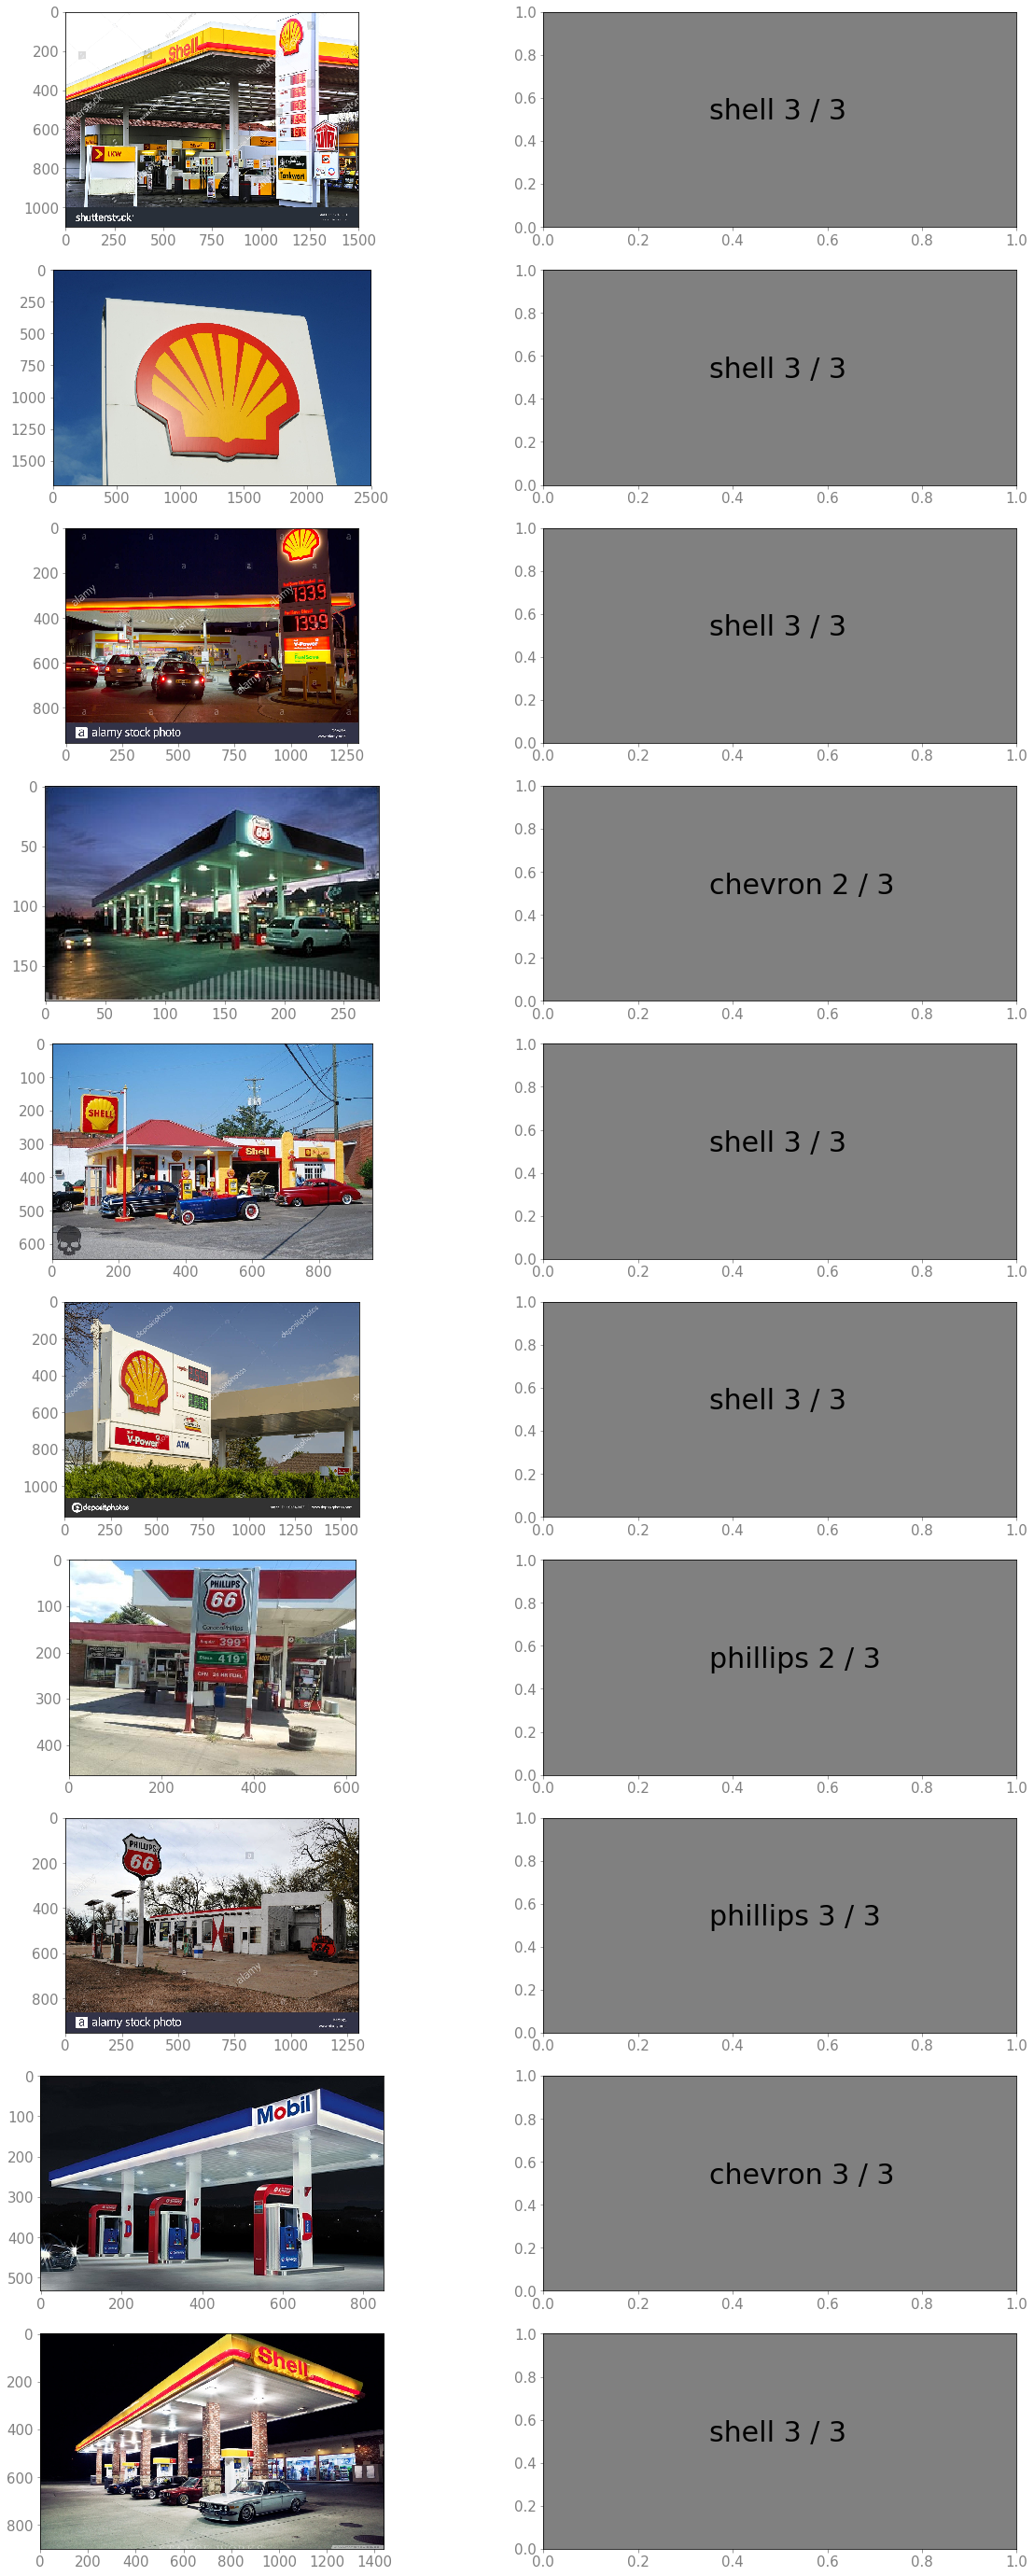

In [0]:
# Let's first filter all the files and keep the images
filenames_test = [name for name in os.listdir(dir_test) if os.path.isfile(os.path.join(dir_test, name))]

print(f'We found the following valid test images:')
for filename_test in filenames_test:
    # check for the extension that it's really an image
    extension = filename_test.split('.')[-1]
    if extension in ['png', 'jpg', 'jpeg']:
        print(filename_test)
    else:
        filenames_test.remove(filename_test)

# Here is the empty dataframe with the predictions        
pred_labels = pd.DataFrame(filenames_test, columns=['fname'])
pred_labels.set_index('fname', inplace=True, drop=True)

# Looping now through our models to see what they predict
for i in range(config.n_folds):
    print(f'\nLoaded model in {dir_log}/best_{i}.h5')
    model.load_weights(os.path.join(dir_log,'best_%d.h5'%i))
    
    test_generator = DataGenerator(config, dir_data=dir_test, list_IDs=filenames_test, shuffle=False, augmentation = augmentation_val, batch_size=pred_labels.shape[0])   
    
    # as before, we will predict it many time to reduce the variance due to cropping
    pred_list = []
    for j in range(config.n_preds):
        print(f'Prediction number {j+1}:')
        prediction = model.predict_generator(test_generator, use_multiprocessing=False, max_queue_size=10, verbose=1)
        pred_list.append(prediction)
    
    # Taking a geometric mean of the probabilities
    prediction = np.ones_like(pred_list[0])
    for pred in pred_list:
        prediction = prediction*pred
    prediction_gm = prediction**(1./len(pred_list))
    
    # Finally saving these predictions in the dataframe
    for nbr_im, filename in enumerate(filenames_test):       
        pred_labels.loc[filename,f'Pred {i}'] = (prediction_gm.argmax(axis=1)[nbr_im])
    pred_labels.loc[:,f'Pred {i}'] = pred_labels.loc[:,f'Pred {i}'].astype(int)
    
print('\nHere is the most common prediction for each image:')

# For each image find its most given prediction, and display the image with that prediction
from google.colab.patches import cv2_imshow
_, ax = plt.subplots(len(filenames_test),2, figsize=(20,5*len(filenames_test)))


for i, filename_test in enumerate(filenames_test):
    img = cv2.cvtColor(cv2.imread(os.path.join(dir_test, filename_test)), cv2.COLOR_RGB2BGR) # convert in normal colors
    
    most_pred_val = pred_labels.loc[filename_test].value_counts().index[0].astype(int)
    most_pred_freq = pred_labels.loc[filename_test].value_counts().values[0].astype(int)
    
    ax[i,0].imshow(img)
    ax[i,1].text(0.35, 0.5, f'{idx_to_labels[most_pred_val]} {most_pred_freq} / {config.n_folds}', dict(size=30))

plt.show()